In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from copy import deepcopy

Utility Functions:

In [2]:
def plot_decision_regions(X , Y , classifier , test_idx_range = None , resolution = 0.02 ):
  markers = ('o' , '^' , 's' , '>' , 'v')
  x1_min, x1_max = X[:,0].min() - 1 , X[:,0].max() + 1
  x2_min, x2_max = x[:,1].min() - 1 , X[:,1].max() + 1
  xx1 , xx2 = np.meshgrid(np.arange(x1_min , x1_max , resolution), np.arange(x2_min , x2_max , resolution))
  lab = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T).reshape(xx1.shape)
  plt.contourf(xx1 , xx2 , lab , cmap=plt.cm.Pastel1)

  for idx , val in enumerate(np.unique(Y)):
    plt.scatter(X[Y==val,0], X[Y==val,1] , c = [plt.cm.Viridis(val/np.unique(Y).sum())] , marker = markers[idx])

Datasets:

In [3]:
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(s, header =None , encoding = 'utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


(0.3, 2.3)

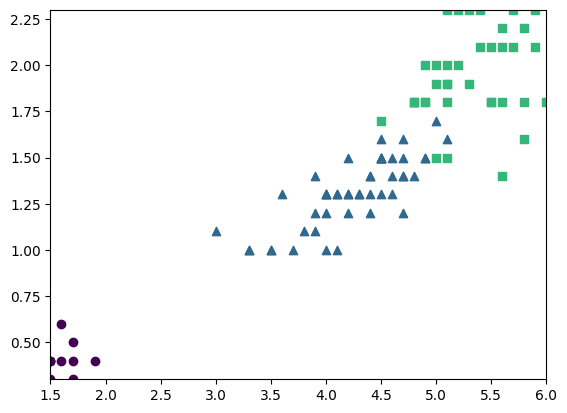

In [4]:
X_iris= df.iloc[:,[2,3]].values
from sklearn.preprocessing import LabelEncoder
Y_iris = LabelEncoder().fit_transform(df.iloc[:,4].values)
for class_number , class_val in enumerate(np.unique(Y_iris)):
  plt.scatter(X_iris[Y_iris==class_val,0] , X_iris[Y_iris==class_val,1], c = [plt.cm.viridis(class_number/np.unique(Y_iris).sum())], marker = ['o', '^', 's'][class_number])
plt.xlim(1.5,6)
plt.ylim(0.3,2.3)


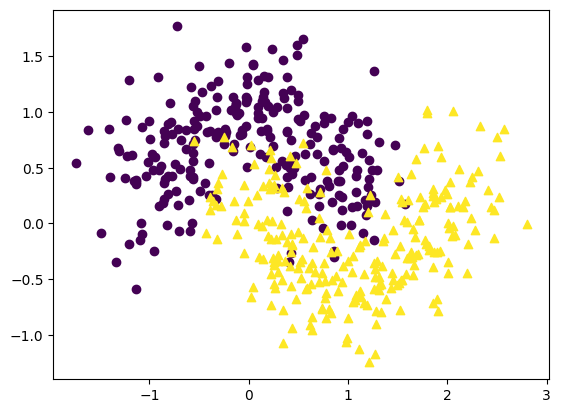

In [5]:
from sklearn.datasets import make_moons
X_moon , Y_moon = make_moons(n_samples = 500 , noise = 0.3 , random_state = 42)
for cl , val in enumerate(np.unique(Y_moon)):
  plt.scatter(X_moon[Y_moon==val,0], X_moon[Y_moon==val,1], c=[plt.cm.viridis(cl/np.unique(Y_moon).sum())], marker = ['o', '^'][cl])

Text(0, 0.5, 'y')

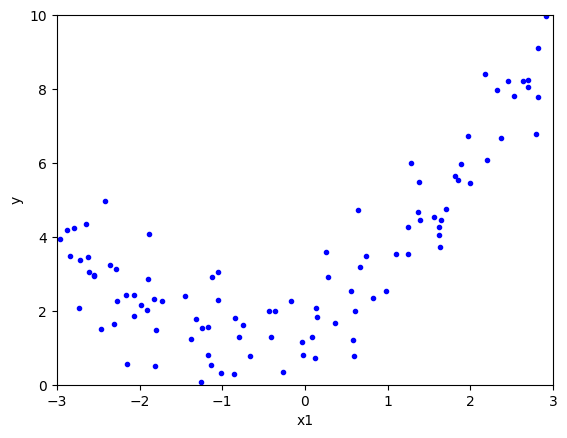

In [6]:
np.random.seed(42)
X_reg_nonlinear = 6*np.random.rand(100,1) - 3
Y_reg_nonlinear = 0.5 * X_reg_nonlinear**2 + X_reg_nonlinear + 2 + np.random.randn(100,1)
Y_reg_nonlinear = Y_reg_nonlinear.ravel()
plt.plot(X_reg_nonlinear[:,0], Y_reg_nonlinear ,'b.')
plt.ylim(0,10)
plt.xlim(-3,3)
plt.xlabel('x1')
plt.ylabel('y')

Models:

In [7]:
from sklearn.linear_model import LinearRegression
linreg = sklearn.linear_model.LinearRegression()

In [8]:
from sklearn.pipeline import make_pipeline
polytransform = sklearn.pipeline.make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree =2 ,include_bias = False))

In [9]:
train_sizes , train_scores , valid_scores = sklearn.model_selection.learning_curve(linreg, sklearn.preprocessing.PolynomialFeatures(degree = 2 , include_bias = False).fit_transform(X_reg_nonlinear), Y_reg_nonlinear ,
                                                                                   train_sizes = np.linspace(0.01 ,1 , 40),
                                                                                   cv =5 ,
                                                                                   scoring = 'neg_root_mean_squared_error')
train_scores = -train_scores.mean(axis = 1)
valid_scores = -valid_scores.mean(axis = 1)

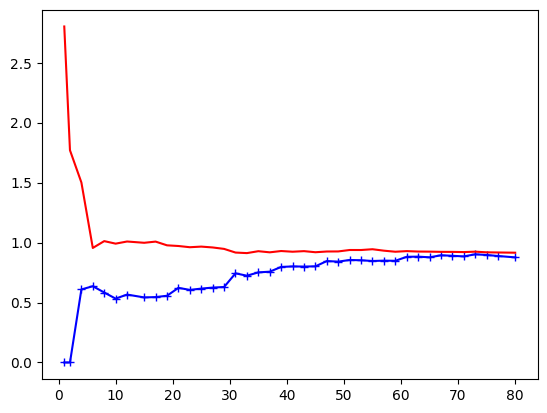

In [10]:
plt.plot(train_sizes, train_scores , 'b-+')
plt.plot(train_sizes, valid_scores , 'r-')

In [11]:
polytransform_h = sklearn.pipeline.make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree= 10 , include_bias=False))

In [12]:
X_poly_train, X_poly_test , Y_reg_nonlinear_train , Y_reg_nonlinear_test = sklearn.model_selection.train_test_split(X_reg_nonlinear , Y_reg_nonlinear ,
                                                                                                                   test_size = 0.3 ,
                                                                                                                   random_state =42)
X_poly_train = polytransform.fit_transform(X_poly_train)
X_poly_test = polytransform.steps[0][1].fit_transform(X_poly_test)

In [13]:
sgdreg = sklearn.linear_model.SGDRegressor(penalty = None , eta0 = 0.002 , random_state = 42)
linreg.fit(X_poly_train, Y_reg_nonlinear_train)

LinearRegression()

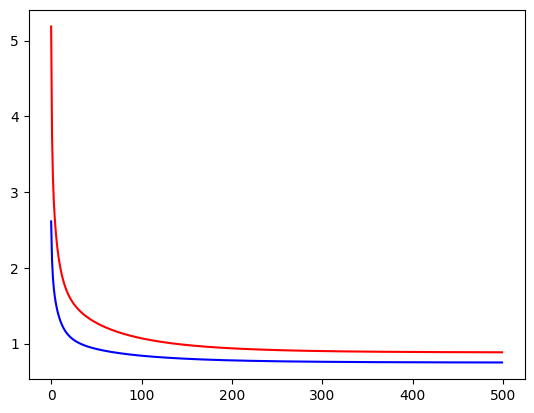

In [14]:
from sklearn.metrics import mean_squared_error
best_rmse = float('inf')
epochs = 500
test_errors = []
train_errors = []
for epoch in range(epochs):
  sgdreg.partial_fit(X_poly_train, Y_reg_nonlinear_train)
  Y_pred_test = sgdreg.predict(X_poly_test)
  train_rmse = mean_squared_error(Y_reg_nonlinear_train , sgdreg.predict(X_poly_train))
  rmse = mean_squared_error(Y_reg_nonlinear_test , Y_pred_test , squared = False)
  test_errors.append(rmse)
  train_errors.append(train_rmse)
  if rmse<best_rmse:
    best_rmse = rmse
    best_fit_epoch = epoch
    best_model = deepcopy(sgdreg)
plt.plot(np.arange(len(train_errors)), train_errors , 'r-')
plt.plot(np.arange(len(test_errors)), test_errors , 'b-')

In [15]:
print(sgdreg.coef_)
print(linreg.coef_)
print(best_fit_epoch)

[0.92828929 0.56128928]
[0.929247   0.54509661]
499


In [16]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1, random_state = 42)
lasso_reg.fit(X_poly_train, Y_reg_nonlinear_train)

Lasso(alpha=0.1, random_state=42)

In [17]:
#lasso_reg.coef_
lasso_reg.score(X_poly_test, Y_reg_nonlinear_test)

0.8955373969664775

In [18]:
lasso_train_sizes , lasso_train_scores , lasso_valid_scores = sklearn.model_selection.learning_curve(lasso_reg ,
                                                                                                     X_poly_train , Y_reg_nonlinear_train ,
                                                                                                     cv = 5,
                                                                                                     scoring = 'neg_root_mean_squared_error',
                                                                                                     )
lasso_train_scores = -lasso_train_scores.mean(axis = 1)
lasso_valid_scores = -lasso_valid_scores.mean(axis = 1)

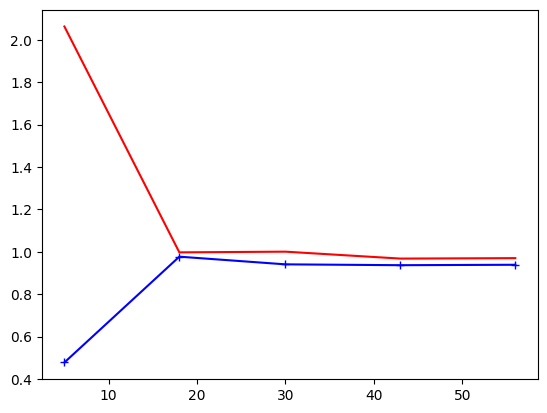

In [19]:
plt.plot(lasso_train_sizes ,  lasso_train_scores , 'b-+')
plt.plot(lasso_train_sizes , lasso_valid_scores, 'r-')

In [20]:
linsvr = sklearn.svm.LinearSVR(epsilon = 0.1 , C = 1, random_state = 42)
linsvr.fit(X_poly_train , Y_reg_nonlinear_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=1, epsilon=0.1, random_state=42)

In [21]:
def line_of_best_fit(classifier, X, Y , resolution = 0.02):
  x_min , x_max = X[:,0].min() - 1 , X[:,0].max() + 1
  X_in = np.arange(x_min, x_max , resolution).reshape(-1,1)
  line = classifier.predict(sklearn.preprocessing.PolynomialFeatures(degree = 2 , include_bias = False).fit_transform(X_in))
  plt.plot(X_in[:,0], line , 'r-')
  plt.scatter(X[:,0], Y , color = 'b', marker = '.')
  plt.xlabel('x1')
  plt.ylabel('y')

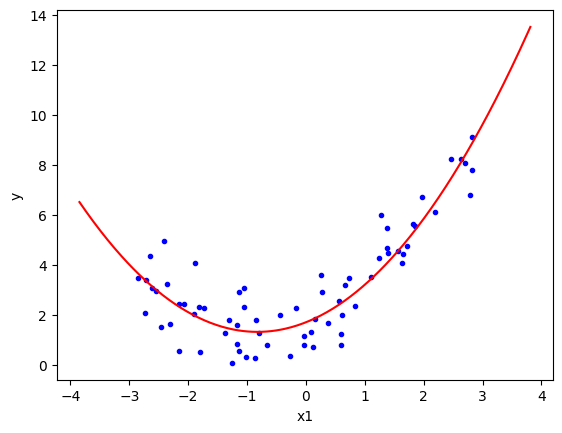

In [22]:
line_of_best_fit(linsvr , X_poly_train , Y_reg_nonlinear_train)

In [23]:
rmse_linsvr = sklearn.metrics.mean_squared_error(Y_reg_nonlinear_test, linsvr.predict(X_poly_test), squared = False)
rmse_linsvr

0.7354203743141732

In [24]:
from sklearn.preprocessing import StandardScaler
scalereg = sklearn.pipeline.make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree = 2 , include_bias = False),
                                          sklearn.preprocessing.StandardScaler())
X_poly_scaled_train = scalereg.fit_transform(X_poly_train)
X_poly_scaled_test = scalereg.steps[0][1].fit_transform(X_poly_test)
X_poly_scaled_test = scalereg.steps[1][1].transform(X_poly_scaled_test)

In [25]:
linreg1 = sklearn.linear_model.LinearRegression()
linreg1.fit(X_poly_scaled_train, Y_reg_nonlinear_train)

LinearRegression()

In [26]:
linreg1.predict(X_poly_scaled_test)

array([3.06738652, 7.17423545, 5.10788532, 3.30547411, 1.59394577,
       1.23863306, 1.41055244, 6.67090249, 3.31706314, 1.17021727,
       1.21639902, 2.55242611, 5.86218388, 7.91794608, 2.64865805,
       2.35331044, 5.09090792, 2.995078  , 6.1553132 , 2.23582272,
       7.56792637, 7.05699475, 2.00599942, 3.24633628, 8.31675502,
       2.13291397, 2.62908051, 1.68566833, 4.01769426, 3.38187305])

In [27]:
linreg.predict(X_poly_test)

array([3.06369052, 7.01958722, 4.73149054, 3.18362186, 1.55607256,
       1.49576439, 1.44807317, 6.37087357, 3.59642971, 1.368535  ,
       1.47060363, 2.58573467, 5.47085504, 8.21600643, 2.47789658,
       2.16320756, 4.7156648 , 2.94469462, 5.78143485, 2.05238435,
       7.60385422, 6.8602757 , 1.85464981, 3.41740205, 9.12570645,
       1.96089902, 2.45515202, 1.89604473, 3.76884484, 3.80030943])

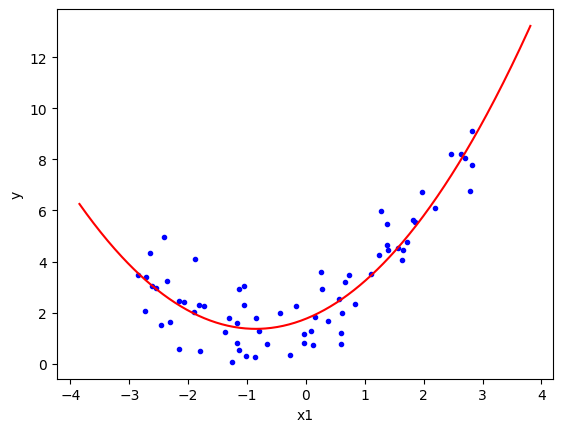

In [28]:
line_of_best_fit(linreg , X_poly_train , Y_reg_nonlinear_train)

In [29]:
rmse_linreg = sklearn.metrics.mean_squared_error(Y_reg_nonlinear_test , linreg.predict(X_poly_test), squared =False)
rmse_linreg

0.7501372514840566

In [30]:
from sklearn.tree import DecisionTreeRegressor
DTReg = sklearn.tree.DecisionTreeRegressor(max_depth = 3 , random_state = 42)

In [31]:
DTReg.fit(X_poly_train , Y_reg_nonlinear_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

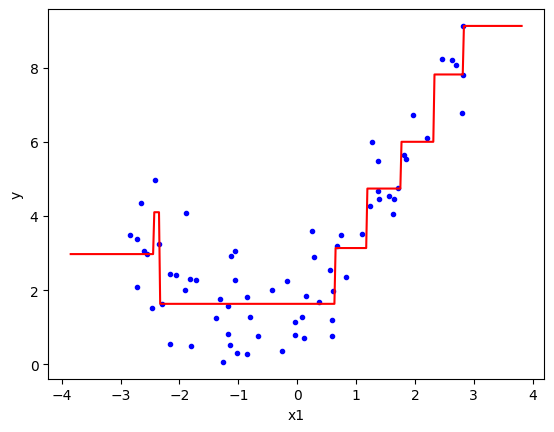

In [32]:
line_of_best_fit(DTReg , X_poly_train , Y_reg_nonlinear_train)